In [34]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

# Tuning stdev parameter

In [160]:
dfs = []
skill_stdev = 1.5
directory = f"data/sims/bias_{skill_stdev}skill"
for filename in os.listdir(directory):
    if filename[-4:] != ".csv":
        continue
    df = pd.read_csv(f"{directory}/{filename}")
    df["sim_num"] = int(filename[:-4])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

0.00000, 0.22722


/Users/markrothery/miniforge3/envs/fastai_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


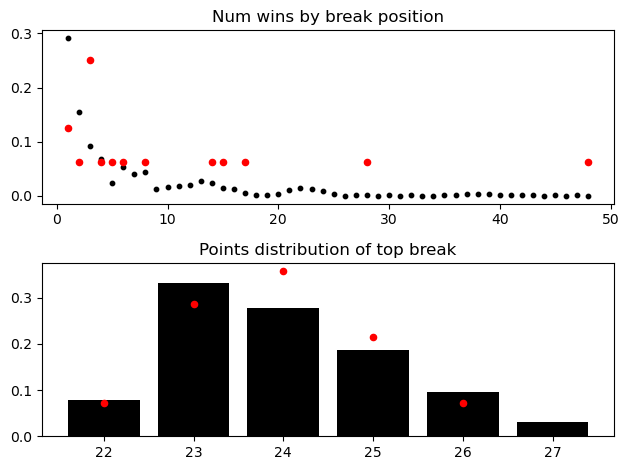

In [52]:
# The long and short of it
fig, ax = plt.subplots(nrows=2)
num_sims = len(df["sim_num"].unique())

break_pos_wins = pd.Series(
    df[df["survived_final"] == True]["break"].value_counts(), 
    index=range(1, 49)
).fillna(0) / num_sims
ax[0].scatter(break_pos_wins.index, break_pos_wins, s=10, color="black")
ax[0].set_title("Num wins by break position")

top_break_pts = pd.Series(df[df["break"] == 1]["points"].value_counts()).fillna(0) / num_sims
ax[1].bar(top_break_pts.index, top_break_pts, color="black")
ax[1].set_title("Points distribution of top break")


winner_ranks = pd.Series([2, 3, 3, 5, 1, 3, 14, 6, 17, 8, 15, 4, 48, 28, 1, 3])
winner_prob = np.exp(np.log(break_pos_wins.loc[winner_ranks]).mean())
wc = winner_ranks.value_counts() / len(winner_ranks)
ax[0].scatter(wc.index, wc, color="red", s=20, alpha=1)
top_breaks = pd.Series([23, 24, 23, 23, 25, 24, 22, 25, 24, 25, 26, 24, 23, 24])
top_break_prob = np.exp(np.log(top_break_pts.loc[top_breaks]).mean())
tb = top_breaks.value_counts() / len(top_breaks)
ax[1].scatter(tb.index, tb, color="red", s=20, alpha=1)
print(f"{winner_prob:.5f}, {top_break_prob:.5f}")

plt.tight_layout()
plt.show()

In [53]:
# For tuning priors
diff = (
    df[df["break"] == 1].set_index("sim_num")["skill"]
    - df[df["break"] == 32].set_index("sim_num")["skill"]
)
print(f"{(1 / (1 + np.exp(-diff))).mean():.4f}")

0.9065


# P(win | best)

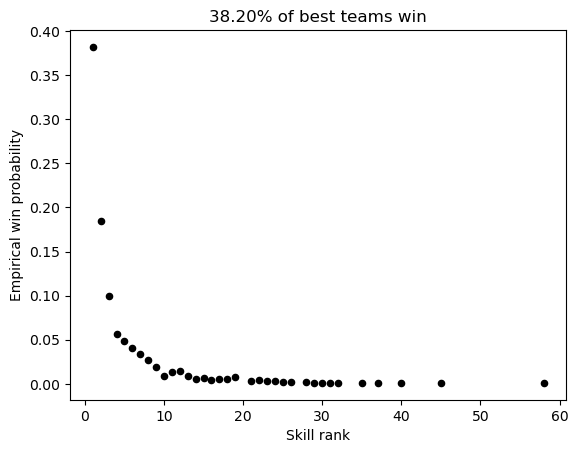

In [141]:
# Get wins by skill rank
# (note only put dots where a team won - blank means no team of that skill rank won)
fig, ax = plt.subplots()
data = df[df["survived_final"] == True]["skill_rank"].value_counts()
ax.scatter(data.index, data / num_sims, s=20, color="black")
ax.set_title(f"{data.loc[1] / num_sims * 100:.2f}% of best teams win")
ax.set_xlabel("Skill rank")
ax.set_ylabel("Empirical win probability")
plt.show()

In [146]:
# Try for different amounts of skill stdev
skill_stdev = 10
dfs = []
directory = f"data/sims/bias_{skill_stdev}skill"
for filename in os.listdir(directory):
    if filename[-4:] != ".csv":
        continue
    df = pd.read_csv(f"{directory}/{filename}")
    df["sim_num"] = int(filename[:-4])
    dfs.append(df)
temp_df = pd.concat(dfs, ignore_index=True)
winners = temp_df[temp_df["survived_final"] == True]
print((winners["skill_rank"] == 1).mean())

0.804


# Break analysis

In [55]:
win_df = df[df["survived_final"] == True]

## Diagnostics

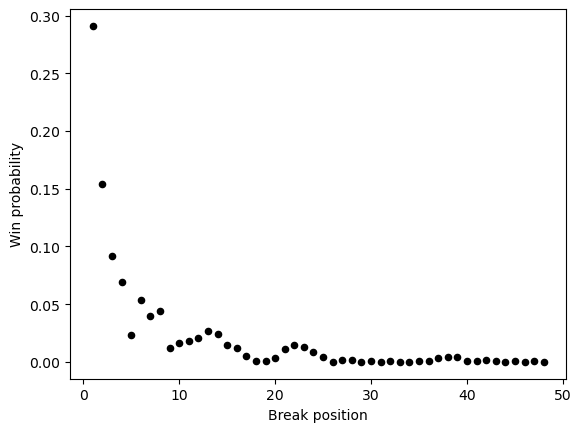

In [147]:
# Go by break position
fig, ax = plt.subplots()
win_data = pd.Series(
    win_df["break"].value_counts() / num_sims,
    index=range(1, 49) # impossible for teams outside these ranks to break
).fillna(0)
ax.scatter(win_data.index, win_data, s=20, color="black")
ax.set_xlabel("Break position")
ax.set_ylabel("Win probability")
plt.show()

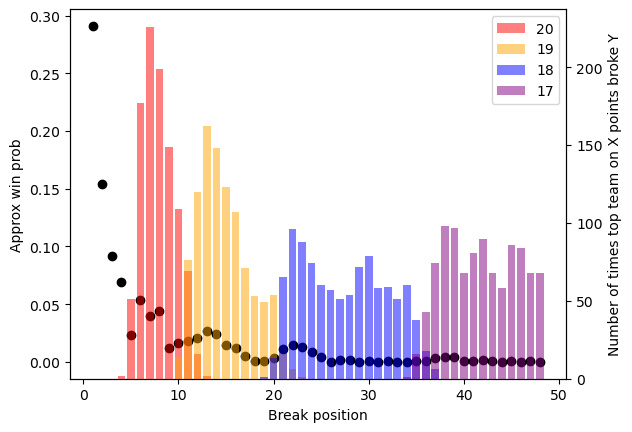

In [153]:
fig, ax = plt.subplots()
# Add in win probs
ax.scatter(win_data.index, win_data, color="black")
ax.set_xlabel("Break position")
ax.set_ylabel("Approx win prob")

# Get hist for top of each bracket
twin = ax.twinx()
for level, colour in zip([20, 19, 18, 17], ["red", "orange", "blue", "purple"]):
    top_level = df[df["points"] == level].groupby("sim_num")["break"].first().value_counts()
    twin.bar(top_level.index, top_level, color=colour, label=level, alpha=0.5)
twin.set_ylabel("Number of times top team on X points broke Y")
twin.legend()
plt.show()

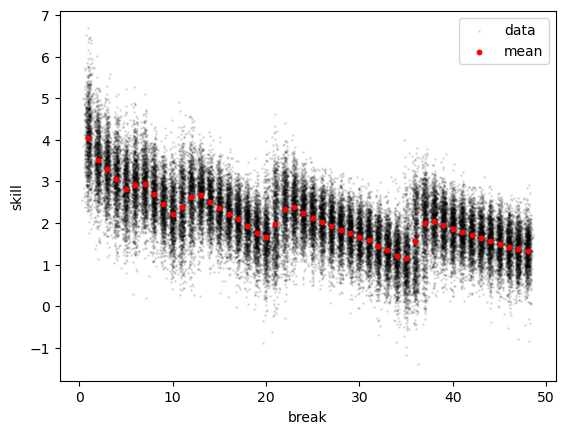

In [58]:
fig, ax = plt.subplots()
jitter = np.random.normal(0, 0.2, len(df))
ax.scatter(df["break"] + jitter, df["skill"], s=1, color="black", alpha=0.1, label="data")
grouped = df.groupby("break")["skill"].mean()
ax.scatter(grouped.index, grouped, s=10, color="red", label="mean")
ax.set_xlabel("break")
ax.set_ylabel("skill")
ax.legend()
plt.show()

## Tapering

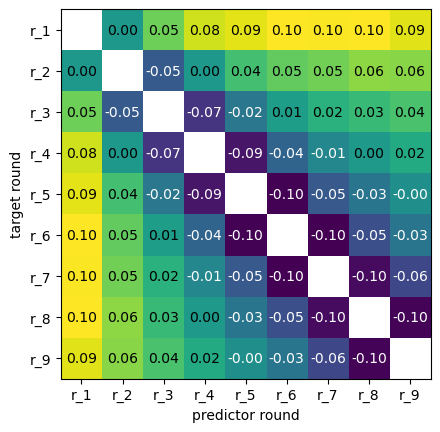

In [154]:
preds = df[[f"r{round_num}_result" for round_num in range(1, 10)]]
betas = preds.cov() / preds.var()
for i in range(9):
    betas.iloc[i, i] = np.nan # Make patterns in the rest show up
fig, ax = plt.subplots()
im = ax.imshow(betas)
ax.set_xticks(range(9), labels=[f"r_{i}" for i in range(1, 10)])
ax.set_yticks(range(9), labels=[f"r_{i}" for i in range(1, 10)])
ax.set_ylabel("target round")
ax.set_xlabel("predictor round")
mid = betas.mean().mean() # hacky way to get sort of midpoint
for i in range(9):
    for j in range(9):
        beta = betas.iloc[j, i]
        colour = "black" if beta > mid else "white"
        ax.text(i, j, f"{beta:.2f}", color=colour, ha="center", va="center")
plt.show()

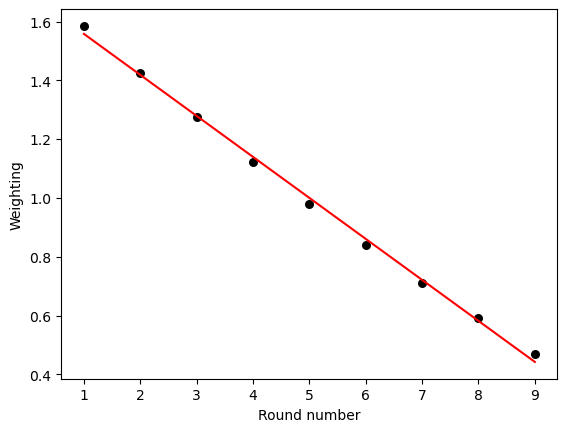

In [59]:
# Get params
preds = df[[col for col in df if "result" in col]]
targ = df["skill"]
taper_model = LinearRegression(fit_intercept=True).fit(preds, targ)
betas = pd.Series(taper_model.coef_, index=range(1, 10))

fig, ax = plt.subplots()
ax.scatter(betas.index, betas / betas.mean(), s=30, color="black")
dummies = pd.DataFrame({0: range(1, 10)})
metamodel = LinearRegression(fit_intercept=True).fit(dummies, betas)
ax.plot(dummies[0], metamodel.predict(dummies) / betas.mean(), color="red")
ax.set_xlabel("Round number")
ax.set_ylabel("Weighting")
plt.show()

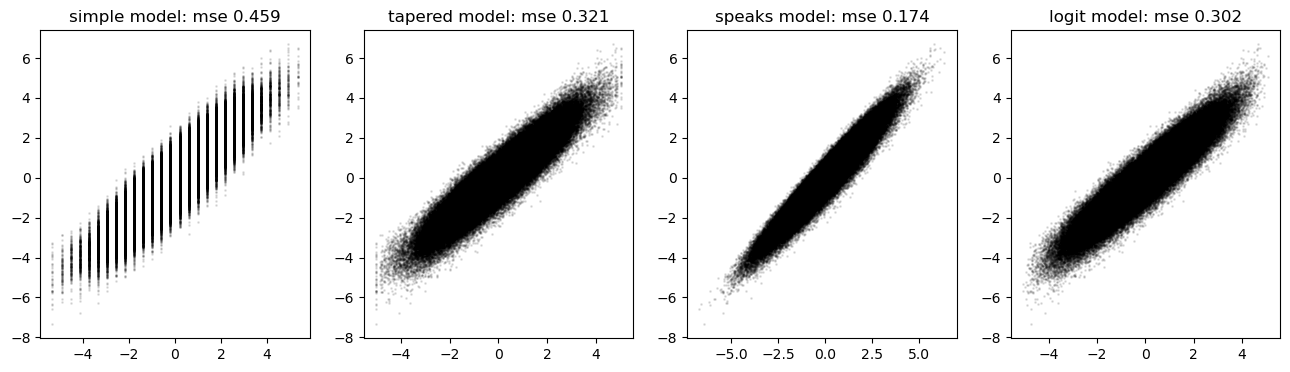

In [68]:
simple_model = LinearRegression(fit_intercept=True).fit(df[["points"]], df["skill"])
speaks_model = LinearRegression(fit_intercept=True).fit(df[["total_speaks"]], df["skill"])
logit_model = LinearRegression(fit_intercept=True).fit(df[["est_skill"]], df["skill"])
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for model, name, axis_num, predictors in zip(
    [simple_model, taper_model, speaks_model, logit_model], 
    ["simple", "tapered", "speaks", "logit"], 
    range(4),
    [df[["points"]], preds, df[["total_speaks"]], df[["est_skill"]]]
):
    predicted = model.predict(predictors)
    ax[axis_num].scatter(predicted, df["skill"], s=1, color="black", alpha=0.1)
    mse = ((predicted - df["skill"]) ** 2).mean()
    ax[axis_num].set_title(f"{name} model: mse {mse:.3f}")
plt.show()

In [81]:
# Now look at robustness of speaks
total_speak_stdev = df["total_speaks"].std()
mses = {}
for noise_mult in np.linspace(0, 1, 21):
    noise = np.random.normal(0, total_speak_stdev * noise_mult, len(df))
    pred = pd.DataFrame({0: df["total_speaks"] + noise})
    temp_model = LinearRegression(fit_intercept=True).fit(pred, df["skill"])
    predictions = pd.Series(temp_model.predict(pred), index=df.index)
    mse = ((predictions - df["skill"]) ** 2).mean()
    mses[noise_mult] = mse
mses = pd.Series(mses)

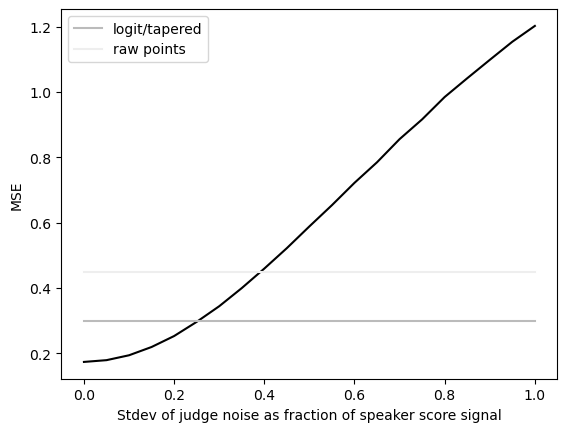

In [93]:
fig, ax = plt.subplots()
ax.plot(mses.index, mses, color="black")
ax.set_xlabel("Stdev of judge noise as fraction of speaker score signal")
ax.set_ylabel("MSE")
ax.plot([0, 1], [0.3, 0.3], color="#bbbbbb", label="logit/tapered")
ax.plot([0, 1], [0.45, 0.45], color="#eeeeee", label="raw points")
ax.legend()
plt.show()

In [95]:
speak_df = pd.read_csv("data/full_wudc_data.csv")
all_speaks = pd.concat([
    speak_df[col] 
    for col in speak_df.columns 
    if "score" in col
])
trimmed = all_speaks[all_speaks > 60]
stdev = trimmed.std()
print(f"Speak stdev in real life: {stdev:.3f}")
print(f"Required judge stdev to be worse than logit/tapered: {stdev * 0.25:.3f}")
print(f"Required judge stdev to be worse than raw points: {stdev * 0.4:.3f}")

Speak stdev in real life: 3.661
Required judge stdev to be worse than logit/tapered: 0.915
Required judge stdev to be worse than raw points: 1.465


## Expland the break?

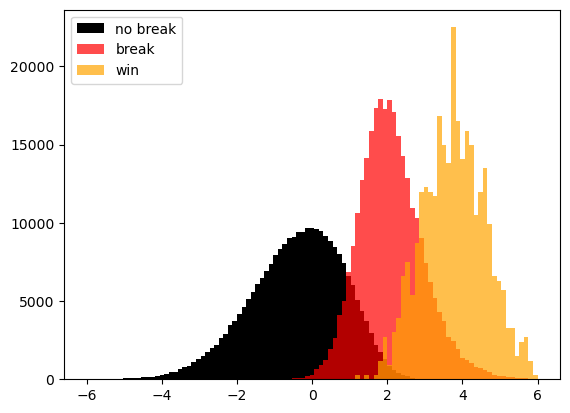

In [103]:
fig, ax = plt.subplots()
bins = np.linspace(-6, 6, 100)
ax.hist(df[df["break"].isna()]["skill"], bins=bins, color="black", label="no break")
ax.hist( # Boost to make histogram the same size
    pd.concat([df[~df["break"].isna()]["skill"] for _ in range(6)]),
    bins=bins, color="red", alpha=0.7, label="break"
)
ax.hist(
    pd.concat([df[df["survived_final"] == True]["skill"] for _ in range(300)]), 
    bins=bins, color="orange", alpha=0.7, label="win"
)
ax.legend()
plt.show()

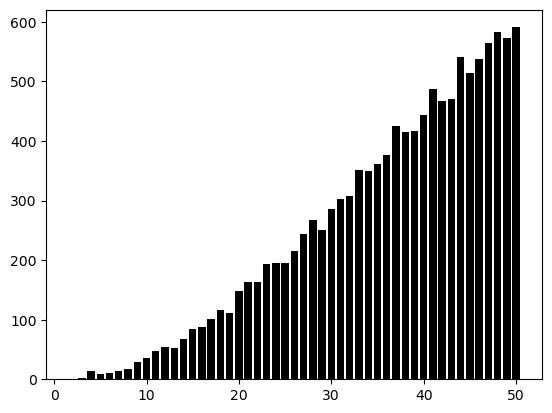

In [107]:
fig, ax = plt.subplots()
nobreaks = df[df["break"].isna()]["skill_rank"].value_counts().sort_index().loc[:50]
ax.bar(nobreaks.index, nobreaks, color="black")
plt.show()

# How often do winners need bias?

In [108]:
sim_1 = df[df["sim_num"] == 1]

In [163]:
def test_winner(df):
    winner_name = df.iloc[0]["name"]
    for final_round in ["pdo", "octo", "quarter", "semi", "final"]:
        room = df.iloc[0][final_round]
        if not room > -100: # catch skipping octo
            continue
        rel_rows = df[
            (df[final_round] == room)
            & (~df[f"survived_{final_round}"].isna())
        ].copy()
        rel_rows["unbiased_speaks"] = (
            rel_rows[f"{final_round}_speaks"] 
            - rel_rows[f"{final_round}_bias"]
        )
        unbiased_progressors = list(rel_rows.sort_values(
            by="unbiased_speaks", ascending=False
        ).iloc[:(2 if final_round != "final" else 1)]["name"])
        if winner_name not in unbiased_progressors:
            return f"lose {final_round}"
    else:
        return "still win"

In [164]:
sim_nums = df["sim_num"].unique()
robust_winner = pd.Series(
    [test_winner(df[df["sim_num"] == sim_num]) for sim_num in sim_nums],
    index=sim_nums
)

In [166]:
robust_winner.value_counts() / len(robust_winner)

still win       0.773
lose final      0.108
lose semi       0.049
lose quarter    0.042
lose octo       0.022
lose pdo        0.006
Name: count, dtype: float64

In [155]:
# Try for different amounts of skill stdev
skill_stdev = 1.5
dfs = []
directory = f"data/sims/nobias_{skill_stdev}skill"
for filename in os.listdir(directory):
    if filename[-4:] != ".csv":
        continue
    df = pd.read_csv(f"{directory}/{filename}")
    df["sim_num"] = int(filename[:-4])
    dfs.append(df)
temp_df = pd.concat(dfs, ignore_index=True)
winners = temp_df[temp_df["survived_final"] == True]
print((winners["skill_rank"] == 1).mean())

0.34


In [179]:
preds = temp_df[[col for col in temp_df.columns if "result" in col]]
model = LinearRegression(fit_intercept=True).fit(preds, temp_df["skill"])
betas = pd.Series(model.coef_, index=range(1, 10))
print(betas / betas.mean())

1    1.598104
2    1.433894
3    1.267973
4    1.124286
5    0.978722
6    0.839703
7    0.702551
8    0.584568
9    0.470199
dtype: float64


Just about the same as before!